In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import seaborn as sns
import random
import optuna
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import pickle

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [44]:
def load_magnetization_data(filepath):
    df = pd.read_excel(filepath)

    metadata = df.iloc[:, :6]

    demag_start = 7
    remag_start = demag_start + 18 + 1
    arm_start = remag_start + 18 + 1

    demag_data = df.iloc[:, demag_start:demag_start + 18]
    remag_data = df.iloc[:, remag_start:remag_start + 18]
    arm_data = df.iloc[:, arm_start:arm_start + 18]

    field_steps = [0, 2.5, 5, 7.5, 10, 15, 20, 25, 30, 40, 50,
                   60, 70, 80, 100, 150, 225, 300]

    processed_data = []

    for idx, row in metadata.iterrows():
        try:
            lava_flow, sample_core, sample_nr = row['sample_name'].split("-")
        except ValueError:
            lava_flow, sample_core, sample_nr = None, None, None  # Handle bad format

        sample = {
            'lava_flow': lava_flow,
            'sample_core': sample_core,
            'sample_nr': sample_nr,
            'series_loc': row['series/loc'],
            'age': row['age'],
            'min_field': row['min field'],
            'max_field': row['max field'],
            'ref_field': row['ref field'],
            'demag': dict(zip(field_steps, demag_data.iloc[idx].values)),
            'remag': dict(zip(field_steps, remag_data.iloc[idx].values)),
            'arm': dict(zip(field_steps, arm_data.iloc[idx].values))
        }
        processed_data.append(sample)

    return pd.DataFrame(processed_data)

# make the dataframe
file_path = 'input_ML_natural.xlsx'
data_complete = load_magnetization_data(file_path)
'''
we drop 'lava_flow','sample_core','sample_nr','series_loc','age' in case there is too little variance between samples-locations.
In MagnetizationDataset._create_features these also need to be commented out.
'''
data = data_complete.drop(['lava_flow','sample_core','sample_nr','series_loc','age'], axis=1) 
data

,min_field,max_field,ref_field,demag,remag,arm
0,5,17,36.01,"{0: 18508975.5915879, 2.5: 18405627.7333863, 5...","{0: 281055.337665022, 2.5: 293981.474552394, 5...","{0: 5128242.97867495, 2.5: 5046510.75223267, 5..."
1,5,16,36.01,"{0: 16949663.8105302, 2.5: 16836047.4746895, 5...","{0: 279334.82030173, 2.5: 310636.499769425, 5:...","{0: 4795899.13943152, 2.5: 4720588.15556917, 5..."
2,3,16,36.01,"{0: 16493907.5883915, 2.5: 16464863.7440125, 5...","{0: 223778.245062472, 2.5: 266595.335480574, 5...","{0: 5483772.96466584, 2.5: 5381797.50552731, 5..."
3,5,16,36.01,"{0: 15624741.6711445, 2.5: 15606841.8128076, 5...","{0: 221062.179626004, 2.5: 235966.458158781, 5...","{0: 4926900.58277006, 2.5: 4822179.4028945, 5:..."
4,6,16,36.01,"{0: 23896177.7474976, 2.5: 24002000.5696941, 5...","{0: 292598.081678795, 2.5: 393701.139779909, 5...","{0: 8146595.84119907, 2.5: 7992660.90704741, 5..."
...,...,...,...,...,...,...
395,7,16,30.20,"{0: 13268840.7741595, 2.5: 13713626.5097894, 5...","{0: 443417.873766946, 2.5: 1253866.38283351, 5...","{0: 11834741.4727487, 2.5: 11225497.4876394, 5..."
396,10,17,30.20,"{0: 21695637.687738, 2.5: 22085295.3668362, 5:...","{0: 460788.287053566, 2.5: 947492.036298458, 5...","{0: 13136947.5091894, 2.5: 12773587.873679, 5:..."
397,9,17,30.20,"{0: 13960249.0385809, 2.5: 14218270.3930682, 5...","{0: 309508.676149797, 2.5: 796689.131356139, 5...","{0: 10564548.3658365, 2.5: 10012962.7376815, 5..."
398,11,17,30.20,"{0: 10635621.9894512, 2.5: 10132667.5318003, 5...","{0: 448027.181858422, 2.5: 1096104.32108262, 5...","{0: 12157114.8037784, 2.5: 11564982.0191833, 5..."


In [48]:
#prep data for training functions
class MagnetizationDataset(Dataset):
    def __init__(self, dataframe, target_col='ref_field', test=False):
        self.data = dataframe
        self.test = test
        self.target_col = target_col
        self.field_steps = np.array([0, 2.5, 5, 7.5, 10, 15, 20, 25, 30, 40, 50, 
                                    60, 70, 80, 100, 150, 225, 300])
        
        # Preprocess data
        self.X_features = []
        self.y = []
        self._create_features()
        self._setup_preprocessor()
        self._transform_features()
    
    def _create_features(self):
        """Create features and store as DataFrame for inspection"""
        feature_records = []
        
        for _, row in self.data.iterrows():
            demag = np.array(list(row['demag'].values()))
            remag = np.array(list(row['remag'].values()))
            arm = np.array(list(row['arm'].values()))
            
            record = {
                # Metadata
                #'lava_flow': row['lava_flow'],
                #'sample_core': row['sample_core'],
                #'sample_nr': row['sample_nr'],
                #'age': row['age'],
                #'series_loc': row['series_loc'],
                'min_field': row['min_field'],
                'max_field': row['max_field'],
                
                # Raw measurements (normalized)
                **{f'demag_{step}': val for step, val in zip(self.field_steps, demag)},
                **{f'remag_{step}': val for step, val in zip(self.field_steps, remag)},
                **{f'arm_{step}': val for step, val in zip(self.field_steps, arm)},
                
                # Engineered features
                'demag_mean': np.mean(demag),
                'demag_std': np.std(demag),
                'demag_integral': np.trapezoid(demag, self.field_steps),
                'remag_mean': np.mean(remag),
                'remag_std': np.std(remag),
                'remag_integral': np.trapezoid(remag, self.field_steps),
                'arm_mean': np.mean(arm),
                'arm_std': np.std(arm),
                'arm_integral': np.trapezoid(arm, self.field_steps),
                'demag_remag_corr': np.corrcoef(demag, remag)[0,1],
            }
            
            feature_records.append(record)
            
            if not self.test:
                self.y.append(row[self.target_col])
        
        self.X_df = pd.DataFrame(feature_records)
        if not self.test:
            self.y = np.array(self.y, dtype=np.float32)
    
    def _setup_preprocessor(self):
        """Setup the preprocessing pipeline"""
        # Auto-detect feature types
        self.numeric_features = [col for col in self.X_df.columns 
                               if col != 'series_loc' and pd.api.types.is_numeric_dtype(self.X_df[col])]
        self.categorical_features = ['series_loc'] if 'series_loc' in self.X_df.columns else []
        
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        
        self.preprocessor = ColumnTransformer([
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features)
        ])
    
    def _transform_features(self):
        """Apply preprocessing"""
        if not hasattr(self, 'preprocessor'):
            self._setup_preprocessor()
            
        # Fit/transform the data first
        self.X = self.preprocessor.fit_transform(self.X_df) if not self.test else self.preprocessor.transform(self.X_df)
        self.X = self.X.astype(np.float32)
        
        # Now we can safely access the transformers
        if len(self.categorical_features) > 0:
            cat_transformer = self.preprocessor.named_transformers_['cat']
            onehot = cat_transformer.named_steps['onehot']
            cat_features = list(onehot.get_feature_names_out(self.categorical_features))
        else:
            cat_features = []
            
        self.feature_names = self.numeric_features + cat_features
    
    def get_feature_info(self):
        """Return feature information for model setup"""
        if len(self.categorical_features) > 0:
            num_encoded_categories = len(
                self.preprocessor.named_transformers_['cat']
                .named_steps['onehot']
                .categories_[0]
            )
        else:
            num_encoded_categories = 0
            
        return {
            'num_numeric_features': len(self.numeric_features),
            'num_categorical_features': len(self.categorical_features),
            'num_encoded_categories': num_encoded_categories,
            'feature_names': self.feature_names,
            'sequence_length': len(self.field_steps)
        }
    
    def __len__(self):
        return len(self.X_df)
    
    def __getitem__(self, idx):
        if not self.test:
            return {
                'features': torch.tensor(self.X[idx], dtype=torch.float32),
                'target': torch.tensor(self.y[idx], dtype=torch.float32)
            }
        return {'features': torch.tensor(self.X[idx], dtype=torch.float32)}

class NoisyMagnetizationDataset(MagnetizationDataset):
    def __init__(self, *args, noise_std=0.0, **kwargs):
        self.noise_std = noise_std
        super().__init__(*args, **kwargs)

    def __getitem__(self, idx):
        sample = super().__getitem__(idx)
        if not self.test and self.noise_std > 0:
            noise = torch.randn_like(sample['features']) * self.noise_std
            sample['features'] += noise
        return sample

def interpolate_samples(dataset, num_augments=5):
    augmented_data = []
    for _ in range(num_augments):
        i, j = np.random.choice(len(dataset), 2, replace=False)
        xi, yi = dataset[i]['features'], dataset[i]['target']
        xj, yj = dataset[j]['features'], dataset[j]['target']
        alpha = np.random.rand()
        x_new = alpha * xi + (1 - alpha) * xj
        y_new = alpha * yi + (1 - alpha) * yj
        augmented_data.append({'features': x_new, 'target': y_new})
    return augmented_data



In [62]:
#setup training and model infracstructure functions
def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

class HybridMagnetizationModel(nn.Module):
    def __init__(self, num_total_features, num_sequence_features=54, sequence_length=18):
        super().__init__()
        
        # CNN branch for sequential data (demag + remag)
        self.conv1d = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # seq len: 18 → 9

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 9 → 4

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
            # Output shape: [batch, 128, 4]
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        # Dense branch for other features
        # Calculate how many features remain after extracting sequential features
        num_tabular_features = num_total_features - num_sequence_features
        self.dense = nn.Sequential(
            nn.Linear(num_tabular_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Final regression head
        self.regressor = nn.Sequential(
            nn.Linear(128 + 128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x_seq, x_feat):
        x_seq = x_seq.view(-1, 3, 18)
        cnn_out = self.conv1d(x_seq)  # shape: [batch, 128, 4]
        cnn_out = cnn_out.permute(0, 2, 1)  # shape: [batch, 4, 128] (for attention over time steps)

        attention_scores = self.attention(cnn_out)  # shape: [batch, 4, 1]
        attention_weights = attention_scores.softmax(dim=1)  # shape: [batch, 4, 1]

        attended = (cnn_out * attention_weights).sum(dim=1)  # shape: [batch, 128]

        feat_features = self.dense(x_feat)  # shape: [batch, 128]

        combined = torch.cat([attended, feat_features], dim=1)  # shape: [batch, 256]

        return self.regressor(combined)

def evaluate_model_with_uncertainty(model, dataloader, mc_runs=30):
    device = next(model.parameters()).device
    model.eval()
    enable_dropout(model)

    all_preds, all_stds, all_targets = [], [], []

    for batch in dataloader:
        features = batch['features'].to(device)
        targets = batch['target'].to(device)
        all_targets.extend(targets.cpu().numpy())

        preds_mc = []
        for _ in range(mc_runs):
            x_seq = features[:, :54].view(-1, 3, 18)
            x_feat = features[:, 54:]
            preds = model(x_seq, x_feat).squeeze()
            preds_mc.append(preds.detach().cpu().numpy())

        preds_mc = np.stack(preds_mc, axis=0)
        mean_preds = preds_mc.mean(axis=0)
        std_preds = preds_mc.std(axis=0)

        all_preds.extend(mean_preds)
        all_stds.extend(std_preds)

    return np.array(all_targets), np.array(all_preds), np.array(all_stds)

def train_model(model, train_loader, val_loader, training_params, save_path=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.SmoothL1Loss()
    optimizer = AdamW(model.parameters(), 
                     lr=training_params['lr'],
                     weight_decay=training_params['weight_decay'])
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Initialize lists to store loss history
    train_losses = []
    val_losses = []
    
    # Create a single progress bar for epochs
    epoch_pbar = tqdm(range(training_params['epochs']), desc='Training')
    
    for epoch in epoch_pbar:
        model.train()
        train_loss = 0
        
        # Inner loop without progress bar
        for batch in train_loader:
            optimizer.zero_grad()
            
            features = batch['features'].to(device)
            targets = batch['target'].to(device)
            
            x_seq = features[:, :54].view(-1, 3, 18)
            x_feat = features[:, 54:]
            
            outputs = model(x_seq, x_feat)
            loss = criterion(outputs.squeeze(), targets)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                targets = batch['target'].to(device)
                
                x_seq = features[:, :54].view(-1, 3, 18)
                x_feat = features[:, 54:]
                
                outputs = model(x_seq, x_feat)
                val_loss += criterion(outputs.squeeze(), targets).item()
        
        avg_val_loss = val_loss / max(1, len(val_loader))
        val_losses.append(avg_val_loss)
        
        # Update progress bar description
        epoch_pbar.set_postfix({
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'lr': optimizer.param_groups[0]['lr']
        })
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            if save_path is not None:
                torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= training_params['patience']:
                print(f'\nEarly stopping at epoch {epoch+1}')
                break
    
    # Load best model if specified
    if save_path is not None:
        model.load_state_dict(torch.load(save_path))
    
    return model, train_losses, val_losses

def load_model(model_class, path, feature_count, sequence_feature_count=54):
    model = model_class(num_total_features=feature_count, num_sequence_features=sequence_feature_count)
    model.load_state_dict(torch.load(path))
    return model

    
def run_k_fold_cross_val(dataframe, model_class, k=3, training_params={}, noise_std=0.0):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    all_importances = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataframe)):
        print(f"\nFold {fold+1}/{k}")
        train_data = dataframe.iloc[train_idx]
        val_data = dataframe.iloc[val_idx]

        train_dataset = NoisyMagnetizationDataset(train_data, noise_std=noise_std)
        val_dataset = MagnetizationDataset(val_data)

        train_loader = DataLoader(train_dataset, batch_size = min(training_params['batch_size'], len(train_dataset) - 1), shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size = min(training_params['batch_size'], len(train_dataset) - 1), drop_last=True)
        if len(train_loader) == 0 or len(val_loader) == 0:
            print(f"Skipping fold {fold+1} due to empty train/val loader.")
            continue
        model = model_class(
            num_total_features=len(train_dataset.feature_names),
            num_sequence_features=54
        )

        model, _, _ = train_model(model, train_loader, val_loader, training_params, save_path=None)
        metrics, _, _ = evaluate_model(model, val_loader, train_dataset.feature_names, plot=False)
        scores.append(metrics)

        importances = calculate_feature_importance(model, val_loader, train_dataset.feature_names)
        all_importances.append(importances)

    return scores, np.array(all_importances)

def train_final_model_and_save(dataframe, model_class, training_params, noise_std, model_path):
    dataset = NoisyMagnetizationDataset(dataframe, noise_std=noise_std)
    loader = DataLoader(dataset, batch_size=training_params['batch_size'], shuffle=True)
    
    model = model_class(
        num_total_features=len(dataset.feature_names),
        num_sequence_features=54
    )
    
    model, _, _ = train_model(model, loader, loader, training_params, save_path=model_path)
    return model

    
def optimize_with_optuna(dataframe, model_class, K_folds, n_trials, 
                         lr_min, lr_max,
                         wd_min, wd_max,
                         noise_min, noise_max,
                         batch_size_min, batch_size_max,
                         epochs_min, epochs_max,
                         patience_min, patience_max):
    feature_importance_store = {}
    trial_params = {}
    
    def objective(trial):
        lr = trial.suggest_float('lr', lr_min, lr_max, log=True)
        wd = trial.suggest_float('weight_decay', wd_min, wd_max, log=True)
        noise = trial.suggest_float('noise_std', noise_min, noise_max)
        batch_size = trial.suggest_int('batch_size', batch_size_min, epochs_max)
        epochs = trial.suggest_int('epochs', epochs_min, epochs_max)
        patience = trial.suggest_int('patience', patience_min, patience_max)

        training_params = {
            'batch_size': batch_size,
            'epochs': epochs,
            'lr': lr,
            'weight_decay': wd,
            'patience': patience
        }

        scores, importances = run_k_fold_cross_val(
            dataframe, model_class, K_folds, training_params=training_params, noise_std=noise)

        mean_r2 = np.mean([score['R2'] for score in scores])
        mean_mae = np.mean([score['MAE'] for score in scores])
        mean_rmse = np.mean([score['RMSE'] for score in scores])

        print(f"R2: {mean_r2:.4f}, MAE: {mean_mae:.4f}, RMSE: {mean_rmse:.4f}")

        feature_importance_store[trial.number] = importances
        trial_params[trial.number] = {
            'batch_size': batch_size,
            'epochs': epochs,
            'lr': lr,
            'weight_decay': wd,
            'noise_std': noise,
            'patience': patience
        }

        score = -(mean_r2 - mean_mae / 2 - mean_rmse / 10)
        return score

    study = optuna.create_study()
    study.optimize(objective, n_trials=n_trials)

    with open("optuna_feature_importances.pkl", "wb") as f:
        pickle.dump(feature_importance_store, f)

    with open("optuna_trial_params.pkl", "wb") as f:
        pickle.dump(trial_params, f)

    return study

def filter_consistently_unimportant_features(importances_array, feature_names, threshold=0):
    importances_mean = importances_array.mean(axis=0)
    consistently_bad_features = [feature_names[i] for i, val in enumerate(importances_mean) if val < threshold]
    return consistently_bad_features

def plot_optuna_trial_feature_importance(trial_number, feature_names, importance_file='optuna_feature_importances.pkl', top_n=72):
    with open(importance_file, 'rb') as f:
        trial_importances = pickle.load(f)

    if trial_number not in trial_importances:
        print(f"Trial number '{trial_number}' not found.")
        return

    importances = trial_importances[trial_number]
    mean_importances = importances.mean(axis=0)
    sorted_idx = np.argsort(mean_importances)[::-1]

    top_features = np.array(feature_names)[sorted_idx][:top_n]
    top_importances = mean_importances[sorted_idx][:top_n]

    plt.figure(figsize=(20, 12))
    sns.barplot(x=top_importances, y=top_features)
    plt.title(f"Feature Importance for Trial #{trial_number}")
    plt.xlabel("Mean Permutation Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


In [93]:
#plotting and output eval functions
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, dataloader, feature_names, plot):
    device = next(model.parameters()).device
    model.eval()
    
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for batch in dataloader:
            features = batch['features'].to(device)
            targets = batch['target'].to(device)
            
            x_seq = features[:, :54].view(-1, 3, 18)
            x_feat = features[:, 54:]
            
            outputs = model(x_seq, x_feat)
            
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(outputs.squeeze().cpu().numpy())
    
    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)
    
    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(all_targets, all_preds),
        'RMSE': np.sqrt(mean_squared_error(all_targets, all_preds)),
        'R2': r2_score(all_targets, all_preds)
    }
    if plot == True:
        # Plot predictions vs true values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_targets, all_preds, alpha=0.6)
        plt.plot([all_targets.min(), all_targets.max()], 
                 [all_targets.min(), all_targets.max()], 'k--')
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('Prediction vs True Value')
        plt.grid(True)
        
        # Add metrics to plot
        textstr = '\n'.join([f'{k}: {v:.4f}' for k, v in metrics.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                      fontsize=10, verticalalignment='top', bbox=props)
        
        plt.show()
    
    return metrics, all_targets, all_preds

def plot_trial_prediction_vs_true_unc(trial_number, dataframe, model_class, feature_names, test_split=0.2, mc_runs=30, model=None):
    with open("optuna_trial_params.pkl", "rb") as f:
        trial_params = pickle.load(f)

    if trial_number not in trial_params:
        print(f"Trial #{trial_number} not found.")
        return

    params = trial_params[trial_number]
    

    train_df, val_df = train_test_split(dataframe, test_size=test_split, random_state=42)

    train_dataset = NoisyMagnetizationDataset(train_df, noise_std=params['noise_std'])
    val_dataset = MagnetizationDataset(val_df)

    batch_size = max(4, min(params.get('batch_size', 32), len(train_dataset) - 1))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

    if model is None:
        print(f"Using trial #{trial_number} with params: {params}")
        model = model_class(num_total_features=len(train_dataset.feature_names), num_sequence_features=54)
        training_config = {
            'batch_size': batch_size,
            'epochs': params.get('epochs', 50),
            'lr': params['lr'],
            'weight_decay': params['weight_decay'],
            'patience': params.get('patience', 5)
        }
        model, _, _ = train_model(model, train_loader, val_loader, training_config,
                                  save_path=f'trained_model_trial_{trial_number}.pth')
    complete_loader = DataLoader(MagnetizationDataset(dataframe), batch_size=batch_size, drop_last=True)
    y_true, y_pred, y_std = evaluate_model_with_uncertainty(model, complete_loader, mc_runs=mc_runs)

    coef = np.polyfit(y_true, y_pred, deg=1)
    fit_fn = np.poly1d(coef)
    x_fit = np.linspace(min(y_true), max(y_true), 100)
    y_fit = fit_fn(x_fit)

    plt.figure(figsize=(10, 6))
    plt.errorbar(y_true, y_pred, yerr=y_std, fmt='o', alpha=0.5, label='Prediction ± Std')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', label='Perfect Fit')
    plt.plot(x_fit, y_fit, 'r-', label='Best Fit')

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Trial #{trial_number} Prediction vs True with Uncertainty')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_trial_prediction_vs_true(trial_number, dataframe, model_class, feature_names, test_split=0.2, model=None):

    # Load trial hyperparameters
    with open("optuna_trial_params.pkl", "rb") as f:
        trial_params = pickle.load(f)

    if trial_number not in trial_params:
        print(f"Trial #{trial_number} not found.")
        return

    params = trial_params[trial_number]
    

    # Split data
    train_df, val_df = train_test_split(dataframe, test_size=test_split, random_state=42)

    max_batch_size = max(4, int(0.8 * len(train_df)))  # 80% rule
    batch_size = min(params['batch_size'], max_batch_size)


    train_dataset = NoisyMagnetizationDataset(train_df, noise_std=params['noise_std'])
    val_dataset = MagnetizationDataset(val_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

    if model is None:
        print(f"Using trial #{trial_number} with params: {params}")
        model = model_class(num_total_features=len(train_dataset.feature_names), num_sequence_features=54)
        training_config = {
            'batch_size': batch_size,
            'epochs': params.get('epochs', 50),
            'lr': params['lr'],
            'weight_decay': params['weight_decay'],
            'patience': params.get('patience', 5)
        }
        model, _, _ = train_model(model, train_loader, val_loader, training_config,
                                  save_path=f'trained_model_trial_{trial_number}.pth')
    complete_loader = DataLoader(MagnetizationDataset(dataframe), batch_size=batch_size, drop_last=True)
    # Plot predictions
    evaluate_model(model, complete_loader, feature_names, plot=True)

def evaluate_model_with_uncertainty(model, dataloader, mc_runs=30):
    device = next(model.parameters()).device
    model.eval()
    enable_dropout(model)

    all_preds, all_stds, all_targets = [], [], []

    for batch in dataloader:
        features = batch['features'].to(device)
        targets = batch['target'].to(device)
        all_targets.extend(targets.cpu().numpy())

        preds_mc = []
        for _ in range(mc_runs):
            x_seq = features[:, :54].view(-1, 3, 18)
            x_feat = features[:, 54:]
            preds = model(x_seq, x_feat).squeeze()
            preds_mc.append(preds.detach().cpu().numpy())

        preds_mc = np.stack(preds_mc, axis=0)
        mean_preds = preds_mc.mean(axis=0)
        std_preds = preds_mc.std(axis=0)

        all_preds.extend(mean_preds)
        all_stds.extend(std_preds)

    return np.array(all_targets), np.array(all_preds), np.array(all_stds)

def plot_predictions_with_uncertainty(y_true, y_pred, y_std):

    plt.figure(figsize=(10, 6))
    plt.errorbar(y_true, y_pred, yerr=y_std, fmt='o', alpha=0.4, label='Predictions ± STD')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', label='Perfect prediction')

    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title('Prediction vs True with Uncertainty')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_trial_predictions_to_excel(trial_number, dataframe, model_class, output_excel_path, model=None, mc_runs=30):

    with open("optuna_trial_params.pkl", "rb") as f:
        trial_params = pickle.load(f)

    if trial_number not in trial_params:
        print(f"Trial #{trial_number} not found.")
        return

    params = trial_params[trial_number]

    # Dataset for prediction
    full_dataset = MagnetizationDataset(dataframe)
    full_loader = DataLoader(full_dataset, batch_size=min(params.get('batch_size', 32), 64), drop_last=False)

    if model is None:
        print(f"Using trial #{trial_number} with params: {params}")
        model = model_class(num_total_features=len(full_dataset.feature_names), num_sequence_features=54)
        training_config = {
            'batch_size': params.get('batch_size', 32),
            'epochs': params.get('epochs', 50),
            'lr': params['lr'],
            'weight_decay': params['weight_decay'],
            'patience': params.get('patience', 5)
        }
        # Train with dummy data loaders if not already trained
        model, _, _ = train_model(model, [], [], training_config,
                                  save_path=f'trained_model_trial_{trial_number}.pth')

    # Get predictions and uncertainty
    y_true, y_pred, y_std = evaluate_model_with_uncertainty(model, full_loader, mc_runs=mc_runs)

    # Save results to Excel
    output_df = dataframe.copy()
    output_df['actual_value'] = y_true
    output_df['predicted_ref_field'] = y_pred
    output_df['std'] = y_std
    output_df['abs_error'] = np.abs(y_true - y_pred)

    output_df.to_excel(output_excel_path, index=False)
    print(f"Saved predictions with uncertainty to: {output_excel_path}")

def predict_and_append_to_excel(input_excel_path, output_excel_path, trial_number, model_class, mc_runs=30, model=None):

    with open("optuna_trial_params.pkl", "rb") as f:
        trial_params = pickle.load(f)

    if trial_number not in trial_params:
        print(f"Trial #{trial_number} not found.")
        return

    params = trial_params[trial_number]

    # Preprocess the raw Excel
    df = load_magnetization_data(input_excel_path)

    dataset = MagnetizationDataset(df)
    loader = DataLoader(dataset, batch_size=min(params.get('batch_size', 32), 64), drop_last=False)

    model.eval()

    _, preds, stds = evaluate_model_with_uncertainty(model, loader, mc_runs=mc_runs)

    # Save predictions back to original raw Excel
    df['predicted_ref_field'] = preds
    df['std'] = stds

    df.to_excel(output_excel_path, index=False)
    print(f"Saved predictions to: {output_excel_path}")


def calculate_feature_importance(model, dataloader, feature_names, n_repeats=5):
    device = next(model.parameters()).device
    model.eval()
    
    # Get all data in one batch
    all_features = []
    all_targets = []
    for batch in dataloader:
        all_features.append(batch['features'])
        all_targets.append(batch['target'])
    
    X = torch.cat(all_features, dim=0).to(device)
    y = torch.cat(all_targets, dim=0).to(device)
    
    # Get baseline score
    with torch.no_grad():
        x_seq = X[:, :54].view(-1, 3, 18)
        x_feat = X[:, 54:]
        baseline_preds = model(x_seq, x_feat).squeeze()
        baseline_mse = F.mse_loss(baseline_preds, y).item()
    
    # Initialize importance scores
    importance_scores = np.zeros(len(feature_names))
    
    # Calculate importance for each feature
    for i in tqdm(range(len(feature_names)), desc="Calculating feature importance"):
        total_mse = 0.0
        
        for _ in range(n_repeats):
            # Create perturbed copy
            X_perturbed = X.clone()
            
            # Permute the current feature
            if i < 54:  # Sequential features
                # For sequential features, maintain the structure
                perm_idx = torch.randperm(X.size(0))
                if i < 18:  # Demag features
                    X_perturbed[:, i] = X[perm_idx, i]
                if 18 < i < 36:  # Remag features
                    X_perturbed[:, i] = X[perm_idx, i]
                else:  # arm features
                    X_perturbed[:, i] = X[perm_idx, i]
            else:  # Tabular features
                perm_idx = torch.randperm(X.size(0))
                X_perturbed[:, i] = X[perm_idx, i]
            
            # Get predictions with perturbed feature
            with torch.no_grad():
                x_seq = X_perturbed[:, :54].view(-1, 3, 18)
                x_feat = X_perturbed[:, 54:]
                preds = model(x_seq, x_feat).squeeze()
                mse = F.mse_loss(preds, y).item()
            
            total_mse += mse
        
        # Calculate importance as normalized MSE increase
        importance_scores[i] = (total_mse / n_repeats - baseline_mse) / baseline_mse
    
    return importance_scores

def plot_feature_importance(importance_scores, feature_names, top_n=20):
    # Sort features by importance
    sorted_idx = np.argsort(importance_scores)[::-1]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(top_n), importance_scores[sorted_idx][:top_n], align='center')
    plt.yticks(range(top_n), np.array(feature_names)[sorted_idx][:top_n])
    plt.xlabel('Importance (Normalized MSE Increase)')
    plt.title('Top {} Most Important Features'.format(top_n))
    plt.tight_layout()
    plt.show()
    
    # Return sorted features and their importance
    return sorted_idx, importance_scores

def plot_feature_importance(model, dataloader, feature_names, top_n=20):
    device = next(model.parameters()).device
    
    # Get all data in one batch for importance calculation
    all_features = []
    all_targets = []
    for batch in dataloader:
        all_features.append(batch['features'])
        all_targets.append(batch['target'])
    
    X = torch.cat(all_features, dim=0).numpy()
    y = torch.cat(all_targets, dim=0).numpy()
    
    # Define scoring function
    def scoring_function(model, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        with torch.no_grad():
            x_seq = X_tensor[:, :54].view(-1, 3, 18)
            x_feat = X_tensor[:, 54:]
            preds = model(x_seq, x_feat).cpu().numpy()
        return -mean_squared_error(y, preds)
    
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, 
        scoring=scoring_function, n_jobs=-1)
    
    # Get importance scores
    importances = result.importances_mean
    sorted_idx = importances.argsort()[::-1]
    
    # Plot top N features
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importances[sorted_idx][:top_n], 
                y=np.array(feature_names)[sorted_idx][:top_n])
    plt.title('Top {} Most Important Features'.format(top_n))
    plt.xlabel('Permutation Importance')
    plt.tight_layout()
    plt.show()
    
    return importances, np.array(feature_names)[sorted_idx]

In [51]:
'''
data split, and check if all shapes and variables are loading in correctly
'''
# 1. First split: train + (temp) validation
train_df, temp_val_df = train_test_split(data, test_size=0.3, random_state=42)

# 2. Split the temp validation into actual validation and test sets
val_df, test_df = train_test_split(temp_val_df, test_size=0.5, random_state=42)

# Create datasets
train_dataset = MagnetizationDataset(train_df)
val_dataset = MagnetizationDataset(val_df)
test_dataset = MagnetizationDataset(test_df)

# Inspect feature information
feature_info = train_dataset.get_feature_info()
print("Feature Information:")
print(f"- Numeric features: {feature_info['num_numeric_features']}")
print(f"- Categorical features: {feature_info['num_categorical_features']}")
print(f"- Encoded categories: {feature_info['num_encoded_categories']}")
print(f"- Total features after preprocessing: {len(feature_info['feature_names'])}")
print(f"- Sequence length: {feature_info['sequence_length']}")

# Sample feature names
print("\nSample feature names:")
print(feature_info['feature_names'])

# Verify data shapes
sample = train_dataset[0]
print(f"\nSample feature vector shape: {sample['features'].shape}")
print(f"Sample target: {sample['target'] if 'target' in sample else 'N/A'}")

Feature Information:
- Numeric features: 66
- Categorical features: 0
- Encoded categories: 0
- Total features after preprocessing: 66
- Sequence length: 18

Sample feature names:
['min_field', 'max_field', 'demag_0.0', 'demag_2.5', 'demag_5.0', 'demag_7.5', 'demag_10.0', 'demag_15.0', 'demag_20.0', 'demag_25.0', 'demag_30.0', 'demag_40.0', 'demag_50.0', 'demag_60.0', 'demag_70.0', 'demag_80.0', 'demag_100.0', 'demag_150.0', 'demag_225.0', 'demag_300.0', 'remag_0.0', 'remag_2.5', 'remag_5.0', 'remag_7.5', 'remag_10.0', 'remag_15.0', 'remag_20.0', 'remag_25.0', 'remag_30.0', 'remag_40.0', 'remag_50.0', 'remag_60.0', 'remag_70.0', 'remag_80.0', 'remag_100.0', 'remag_150.0', 'remag_225.0', 'remag_300.0', 'arm_0.0', 'arm_2.5', 'arm_5.0', 'arm_7.5', 'arm_10.0', 'arm_15.0', 'arm_20.0', 'arm_25.0', 'arm_30.0', 'arm_40.0', 'arm_50.0', 'arm_60.0', 'arm_70.0', 'arm_80.0', 'arm_100.0', 'arm_150.0', 'arm_225.0', 'arm_300.0', 'demag_mean', 'demag_std', 'demag_integral', 'remag_mean', 'remag_std', '

In [64]:
# train the model and safe the losses
'''
we use optuna. Optuna is a automated program that searches for the best performing model.
We speficy the range of the parameters, and in how many tries (trials) the program has to find the best model
in each trial we use k-folds. We take the average score of all the folds, and that is the performance.
the more folds, the more accurate the average score. But the longer each trial will take

lr_min, lr_max: learning rate, how strict we want to make our training
wd_min, wd_max: weight decay, how fast we want to decrease our learing rate during training
noise_min, noise_max: how much noise we introduce to our data during training
batch_size_min, batch_size_max: how large we want our batch size to be for each training step
epochs_min, epochs_max: how many times we want to go over the data
patience_min, patience_max: how patient we want to be till we conclude that the model is done with relevant training
'''
study = optimize_with_optuna(data, HybridMagnetizationModel, K_folds=2, n_trials=2, 
                         lr_min=1e-3, lr_max=2.5e-3,
                         wd_min=4e-5, wd_max=5e-5,
                         noise_min=0.04, noise_max=0.06,
                         batch_size_min=40, batch_size_max=64,
                         epochs_min=50, epochs_max=60,
                         patience_min=17, patience_max=20
                        )
print("Best Params:", study.best_params)

[I 2025-07-16 15:28:36,779] A new study created in memory with name: no-name-064b0216-95c6-43ec-9e16-ef77ef2d7021



Fold 1/2


Training:   0%|          | 0/51 [00:00<?, ?it/s]

Calculating feature importance:   0%|          | 0/66 [00:00<?, ?it/s]


Fold 2/2


Training:   0%|          | 0/51 [00:00<?, ?it/s]

Calculating feature importance:   0%|          | 0/66 [00:00<?, ?it/s]

[I 2025-07-16 15:28:49,796] Trial 0 finished with value: 2.2428435236038453 and parameters: {'lr': 0.0012933145528258015, 'weight_decay': 4.32723646748752e-05, 'noise_std': 0.04083296276088009, 'batch_size': 55, 'epochs': 51, 'patience': 18}. Best is trial 0 with value: 2.2428435236038453.


R2: 0.4964, MAE: 4.2520, RMSE: 6.1325

Fold 1/2


Training:   0%|          | 0/59 [00:00<?, ?it/s]

Calculating feature importance:   0%|          | 0/66 [00:00<?, ?it/s]


Fold 2/2


Training:   0%|          | 0/59 [00:00<?, ?it/s]

Calculating feature importance:   0%|          | 0/66 [00:00<?, ?it/s]

[I 2025-07-16 15:29:06,270] Trial 1 finished with value: 2.241077378694248 and parameters: {'lr': 0.0016100977649393046, 'weight_decay': 4.1062329304462714e-05, 'noise_std': 0.05368493870056258, 'batch_size': 49, 'epochs': 59, 'patience': 19}. Best is trial 1 with value: 2.241077378694248.


R2: 0.5620, MAE: 4.3402, RMSE: 6.3291
Best Params: {'lr': 0.0016100977649393046, 'weight_decay': 4.1062329304462714e-05, 'noise_std': 0.05368493870056258, 'batch_size': 49, 'epochs': 59, 'patience': 19}


In [68]:
'''
After we've found the best paramers for the best performing model. We can retrain with those params.
And save the model as a .pth file
We can later recall a .pth file with the 
'''
best_params = study.best_trial.params
train_final_model_and_save(
    data,
    HybridMagnetizationModel,
    best_params,
    best_params['noise_std'],
    'best_model_save.pth'
)
model = load_model(HybridMagnetizationModel, 'best_model_save.pth', feature_count=len(feature_info['feature_names']))

Training:   0%|          | 0/59 [00:00<?, ?it/s]

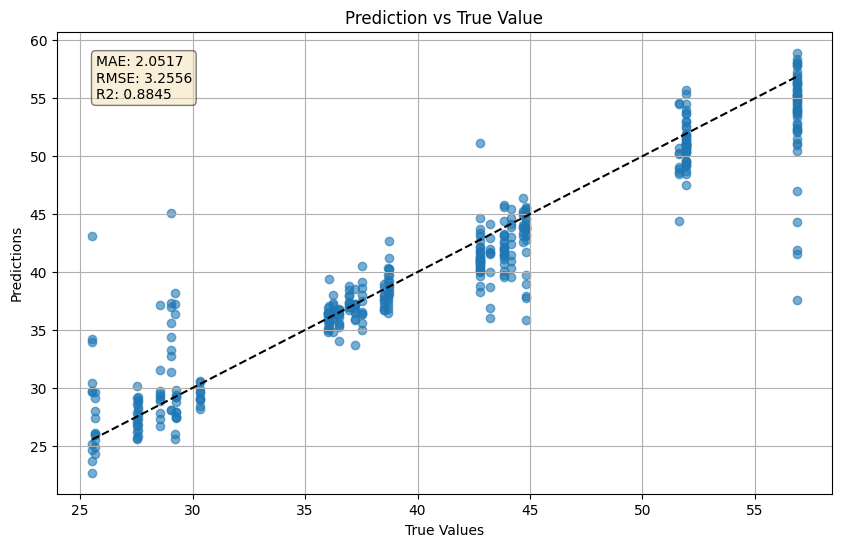

In [100]:
'''
For example:
I 2025-07-16 13:39:57,471] Trial 4 finished with value: X and parameters: {x}. Best is trial 1 with value: x.
in this case we will select the best trial likeso : trial_number=1
But you can select any trial

plot_trial_prediction_vs_true(
    trial_number=1,
    dataframe=data,
    model_class=HybridMagnetizationModel,
    feature_names=train_dataset.feature_names
)
Or you can use the saved model, in that case we can call the function like so:
'''
plot_trial_prediction_vs_true(0, data, HybridMagnetizationModel, train_dataset.feature_names, model=model)
#we select trial 0, but since we specify the model it will override this call. 

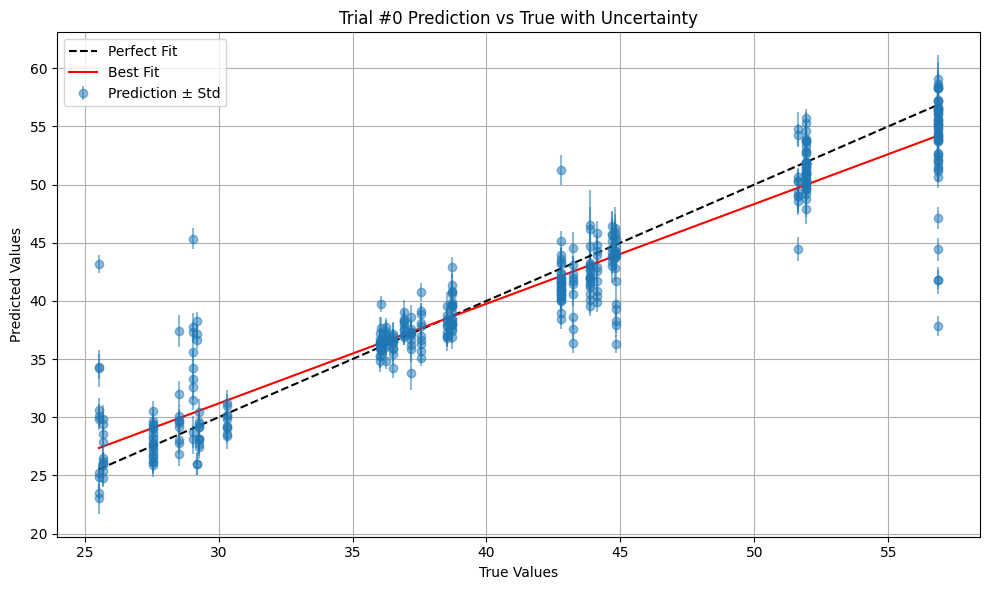

In [95]:
#Plot with Std and plot best fit
'''
same with this plot

plot_trial_prediction_vs_true_unc(
    trial_number=1,
    dataframe=data,
    model_class=HybridMagnetizationModel,
    feature_names=train_dataset.feature_names,
    mc_runs=30
)
'''
plot_trial_prediction_vs_true_unc(0, data, HybridMagnetizationModel, train_dataset.feature_names, model=model)

In [76]:
#safe results of all data predictions in excel
save_trial_predictions_to_excel(
    trial_number=0,
    dataframe=data_complete,
    model_class=HybridMagnetizationModel,
    output_excel_path="natrual_predictions.xlsx",
    model=model
)

Saved predictions with uncertainty to: natrual_predictions3.xlsx


In [92]:
#give new data that doesn't contain a ref_field, and make a new file with predictions
input_excel_path = './input_arm_unknown.xlsx'
output_excel_path = './input_arm_unknown_with_pred.xlsx'
predict_and_append_to_excel(input_excel_path, output_excel_path, 0, HybridMagnetizationModel, mc_runs=30, model=model)

Saved predictions to: ./input_arm_unknown_with_pred.xlsx


In [ ]:
'''
somewhat decrepit but still functional. This shows the normilized feature importance of a optuna trial
'''

# Calculate feature importance
plot_optuna_trial_feature_importance(
    trial_number=1,
    feature_names=train_dataset.feature_names,
    top_n=72
)